# Create a Simple AI Agent

We'll introduce you to AI agents by creating a simple agent that will create a bar graph based on data that we give to it. 

## Connect to your Azure AI Foundry project

In [1]:
import os
from dotenv import load_dotenv


from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import CodeInterpreterTool

load_dotenv(override=True)  # Load environment variables from .env file

try:
    project_client = AIProjectClient(
        credential=DefaultAzureCredential(),
        endpoint=os.environ["AIPROJECT_ENDPOINT"],
    )
    print("✓ Successfully initialized AIProjectClient")
except Exception as e:
    print(f"× Error initializing client: {str(e)}")

✓ Successfully initialized AIProjectClient


## Create the simple AI Agent

In [2]:
from pathlib import Path
from IPython.display import Image, display
model_deployment_name = os.getenv("MODEL_DEPLOYMENT_NAME")

# Create an instance of the CodeInterpreterTool, which is responsible for generating the bar chart
code_interpreter = CodeInterpreterTool()

# The CodeInterpreterTool needs to be included in creation of the agent so that it can be used
agent = project_client.agents.create_agent(
    model=model_deployment_name,
    name="my-agent-barchart",
    instructions="You are a helpful agent.",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)
print(f"Created agent, agent ID: {agent.id}")

# Create a thread which is a conversation session between an agent and a user.
thread = project_client.agents.threads.create()
print(f"Created thread, thread ID: {thread.id}")


Created agent, agent ID: asst_nQ2S0eePplnIn0I6J00nGgox
Created thread, thread ID: thread_YQHzbkRLp60LSoxBVnkpNJrR



## Generate a prompt and send it to the agent

In the next cell, we'll create a prompt containing fruit sales data and ask the agent to generate a grouped bar chart. The prompt will specify the chart requirements, including file name, chart type, colors, title, legend, and y-axis formatting.



In [3]:


prompt = "Could you please create a bar chart for the following fruit sales data and \
provide the file to me? Name the file as fruit-sales-quarterly.png. \
Here is the data: \
Fruit Type,Q1 Sales,Q2 Sales,Q3 Sales,Q4 Sales \
Apples,15000,18000,22000,19000 \
Oranges,12000,14000,16000,17000 \
Bananas,8000,9500,11000,12500 \
Grapes,6000,7500,9000,8500 \
Strawberries,4500,6000,8500,5000 \
Pineapples,3000,3500,4200,4800 \
Please create a grouped bar chart showing quarterly sales for each fruit type, \
with different colors for each quarter. Add a title 'Quarterly Fruit Sales Report' \
and include a legend. Format the y-axis to show sales values in thousands (K)."

# Create a message, with the prompt being the message content that is sent to the model
message = project_client.agents.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

# Run the agent to process the message in the thread
run = project_client.agents.runs.create_and_process(thread_id=thread.id, agent_id=agent.id)
print(f"Run finished with status: {run.status}")

if run.status == "failed":
    # Check if you got "Rate limit is exceeded.", then you want to increase the token limit
    print(f"Run failed: {run.last_error}")


Created message, message ID: msg_8r6TzlYGMiT2jgI9vviqqr9S
Run finished with status: RunStatus.COMPLETED



## Retrieve and display the generated bar chart

The following cell retrieves all messages from the conversation thread, extracts the generated bar chart image from the agent's response, and displays it directly in the notebook.


Messages: <iterator object azure.core.paging.ItemPaged at 0x10dfc1880>
Generated chart (ID: assistant-2fXZ5CbT5hx5WMzoWcuZxX):


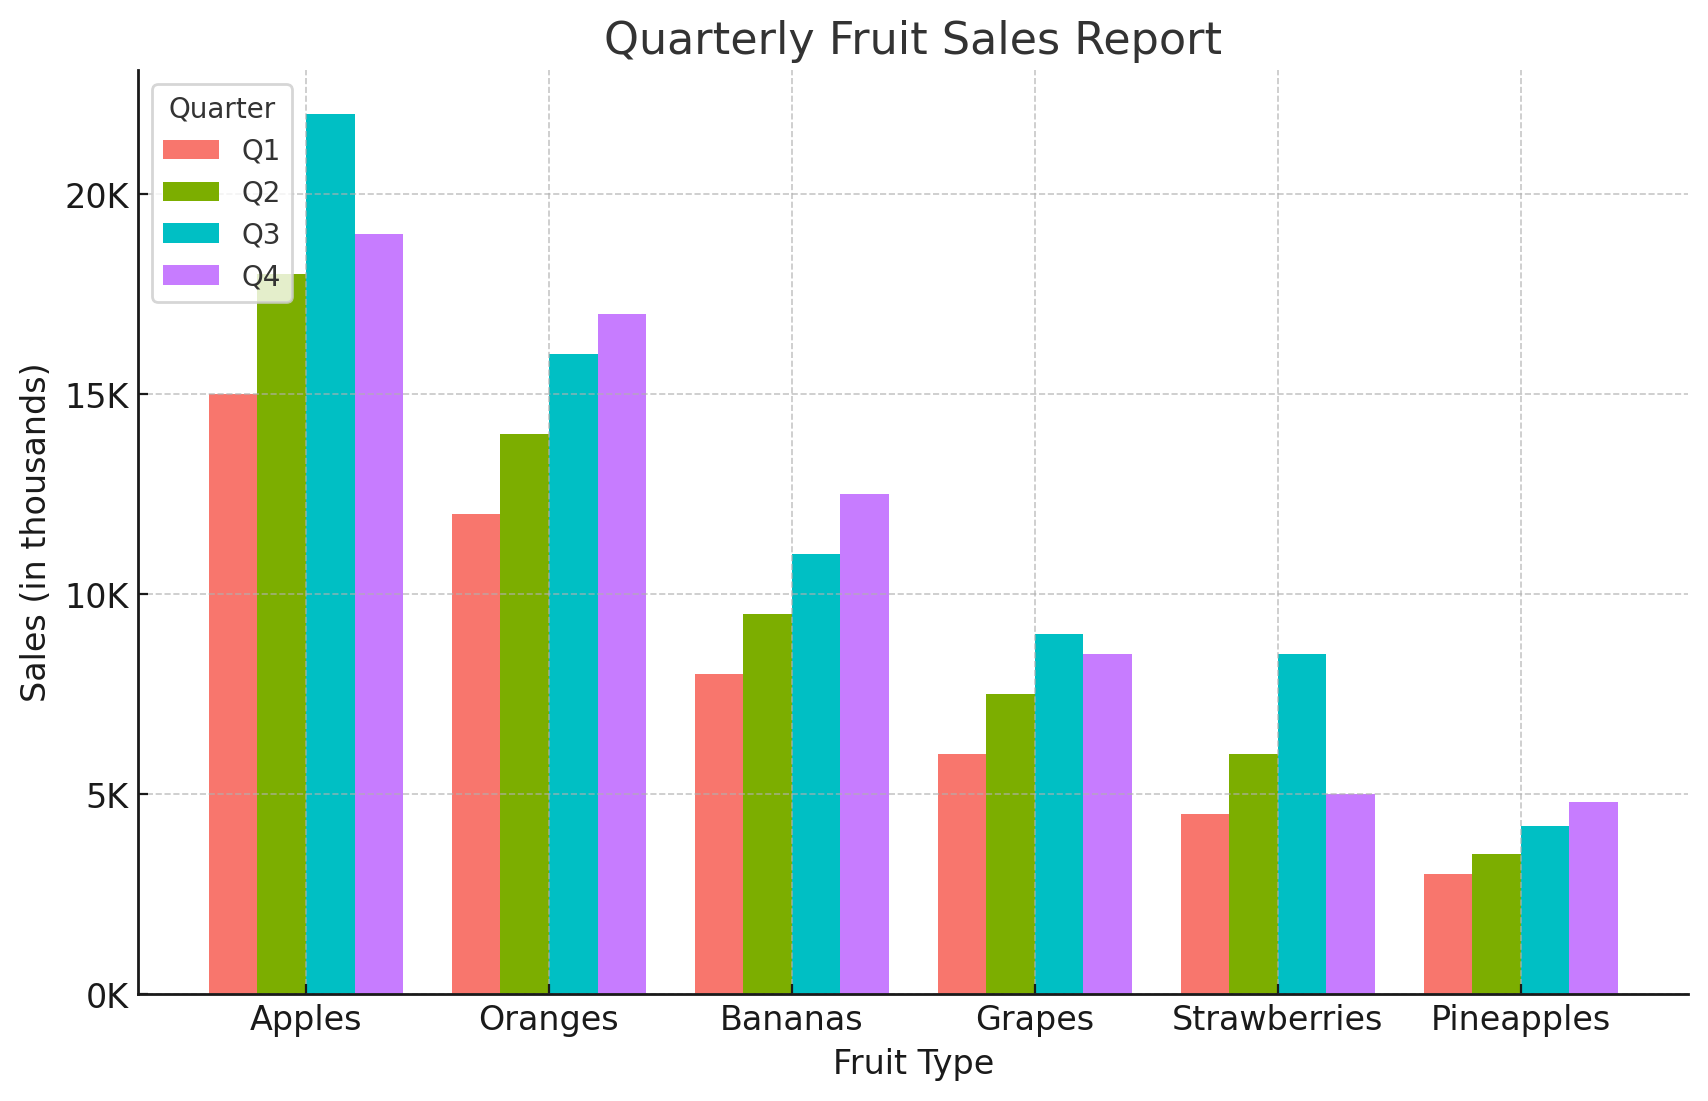

In [4]:
# Get all messages from the thread
messages = project_client.agents.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

# Generate an image file for the bar chart
for message in messages:
    if hasattr(message, "file_path_annotations"):
        for file_path_annotation in message.file_path_annotations:
            file_name = Path(file_path_annotation.text).name
            file_id = file_path_annotation.file_path.file_id
            
            # ✅ CORRECTED: Handle generator and collect all chunks
            file_content_generator = project_client.agents.files.get_content(file_id)
            file_content = b''.join(file_content_generator)
            
            # Display the image directly in the notebook
            print(f"Generated chart (ID: {file_id}):")
            display(Image(data=file_content))

## Cleanup

When you're done testing, it's important to delete the agent to avoid unnecessary costs and resource usage.

In [5]:
# Clean up - Delete the agent
print("Cleaning up agent...")

try:
    project_client.agents.delete_agent(agent.id)
    print("✓ Deleted agent")
    print("\n✓ Agent successfully deleted!")
except Exception as e:
    print(f"× Error during cleanup: {str(e)}")

Cleaning up agent...
✓ Deleted agent

✓ Agent successfully deleted!
✓ Deleted agent

✓ Agent successfully deleted!
